# Born Again Training: 
## Does re-labeling training/validation positives with model predictions in first round of training reduce overfitting to positives in upsampled batches in second round of training? 
Relevant: https://arxiv.org/pdf/1805.04770.pdf
## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Train Model</a></li>
    <li><a href=#3>Performance and Interpretation</a></li>
    <li><a href=#4>Relabel Training/Validation Positives</a></li>  
    <li><a href=#5>Retrain the model from early stoppping phase</a></li>
    <li><a href=#6>Performance and Interpretation on Round 2 </a></li>
    <li><a href=#9>Conclusions</a></li>    
</ol>

In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

#housekeeping
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Inputs <a name='1'>
<a href=#outline>Home</a>

Seqdataloader was used to generate genome-wide regression labels for the SPI TF Chip-seq dataset (see Tutorial 5), yielding these files: 
```
SPI1.train.regression.hdf5
SPI1.valid.regression.hdf5
SPI1.test.regression.hdf5
```
Set of bins with non-zero coverage values: 

In [4]:
from seqdataloader import * 

In [7]:
train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"train.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"valid.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"test.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
got peak subset for chrom:chr9 for task:SPI1
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
got peak subset for chrom:chr7 for task:SPI1
got peak subset for chrom:chr5 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
got peak subset for chrom:chr3 for task:SPI1
finished chromosome:chr9 for task:SPI1
finished chromosome:chr7 for task:SPI1
finished chromosome:chr5 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
got peak subset for chrom:chr10 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
got peak subset for chrom:chr8 for task:SPI1
pre-allocated df for chrom:chr6with dimensions:(3422282, 4)
got peak subset for chrom:ch

## Train the Model <a name='1'>
<a href=#outline>Home</a>

In [8]:
from dragonn.generators import * 

Using TensorFlow backend.


In [9]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [25]:
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=10,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=5,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
   
    model.add(Dense(ntasks))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

In [26]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)


In [27]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  epochs=150,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 180s 18ms/step - loss: 0.0519 - val_loss: 0.0473
Epoch 2/150
10000/10000 [==============================] - 165s 16ms/step - loss: 0.0416 - val_loss: 0.0476
Epoch 3/150
10000/10000 [==============================] - 165s 16ms/step - loss: 0.0414 - val_loss: 0.0476
Epoch 4/150
10000/10000 [==============================] - 165s 17ms/step - loss: 0.0403 - val_loss: 0.0440
Epoch 5/150
10000/10000 [==============================] - 165s 17ms/step - loss: 0.0404 - val_loss: 0.0479
Epoch 6/150
10000/10000 [==============================] - 165s 17ms/step - loss: 0.0402 - val_loss: 0.0473
Epoch 7/150
10000/10000 [==============================] - 165s 17ms/step - loss: 0.0398 - val_loss: 0.0459


In [28]:
## save the model 
spi1_regression_model.save("SPI1.regression.model.hdf5")

In [29]:
loss=pd.DataFrame(history_regression.history)
loss['epoch']=list(loss.index)
loss

,val_loss,loss,epoch
0,0.047289,0.051949,0
1,0.047621,0.041590,1
2,0.047606,0.041352,2
3,0.043968,0.040314,3
4,0.047893,0.040359,4
5,0.047276,0.040245,5
6,0.045928,0.039770,6


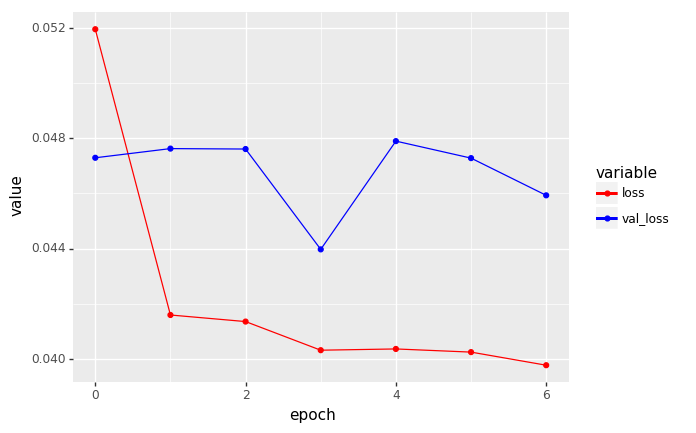

<ggplot: (-9223363258714800538)>

In [30]:
#Plot the loss curves 
from plotnine import *
subset = pd.melt(loss, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
p = ggplot(subset, aes(x='epoch', y='value', color='variable'))
(p + geom_line()
   + geom_point()
   + scale_color_manual(['r', 'b'])
)

## Performance and Interpretation<a name='3'>
<a href=#outline>Home</a>

In [31]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 336s 55ms/step


In [32]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.20853126], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.13863210928388475, pvalue=0.0)


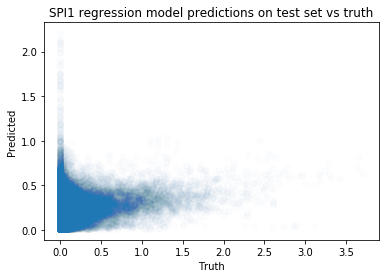

In [33]:
import matplotlib.pyplot as plt
plt.scatter(spi1_test_regression_truth, spi1_test_regression_predictions, alpha=0.01)
plt.xlabel("Truth")
plt.ylabel("Predicted")
plt.title("SPI1 regression model predictions on test set vs truth")
plt.show()

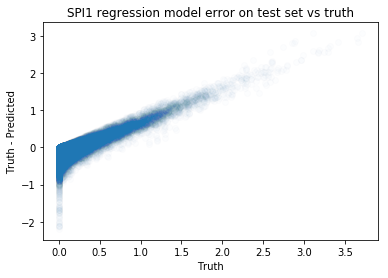

In [34]:
#plot truth vs error to see if we are overfitting to the positives 
error=spi1_test_regression_truth - spi1_test_regression_predictions 
plt.scatter(spi1_test_regression_truth, error, alpha=0.01)
plt.xlabel("Truth")
plt.ylabel("Truth - Predicted")
plt.title("SPI1 regression model error on test set vs truth")
plt.show()

In [42]:
spi1_test_regression_predictions[0:10]

array([[0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014],
       [0.013014]], dtype=float32)

In [75]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence (>0.9)
#get the true positive predictions 
true_pos=spi1_test_regression_truth[(spi1_test_regression_truth.values*spi1_test_regression_predictions)>2]
true_pos.shape

(10, 1)

In [76]:
true_pos.sort_values(by="SPI1").tail()

SPI1
CHR   START    END               
chr19 27731450 27732450  3.290329
      27731650 27732650  3.292384
      27731600 27732600  3.650610
      27731500 27732500  3.663172
      27731550 27732550  3.706765

In [77]:
from dragonn.utils import one_hot_from_bed
deep_lift_input=one_hot_from_bed([i for i in true_pos.index],"/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa")
deep_lift_input.shape

(10, 1, 1000, 4)

In [78]:
from dragonn.tutorial_utils import deeplift 

In [79]:
deep_lift_scores=deeplift(spi1_regression_model,deep_lift_input,target_layer_idx=-1)

In [80]:
from dragonn.tutorial_utils import  plot_seq_importance

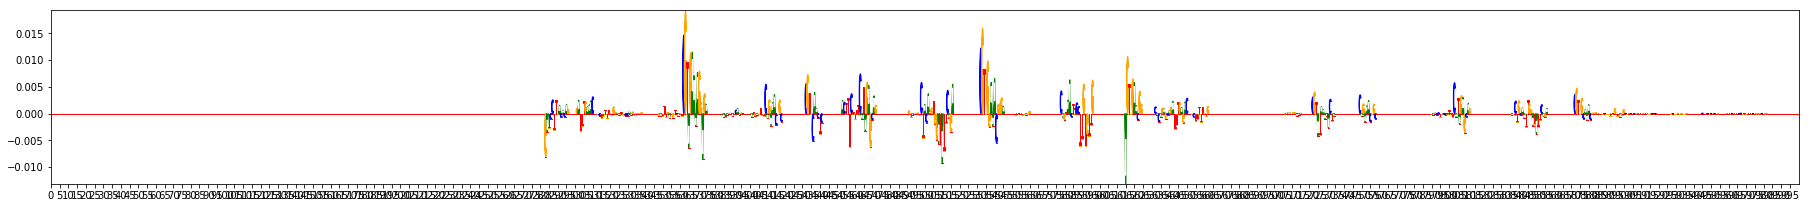

In [92]:
plot_seq_importance(deep_lift_scores[1],deep_lift_input[1])

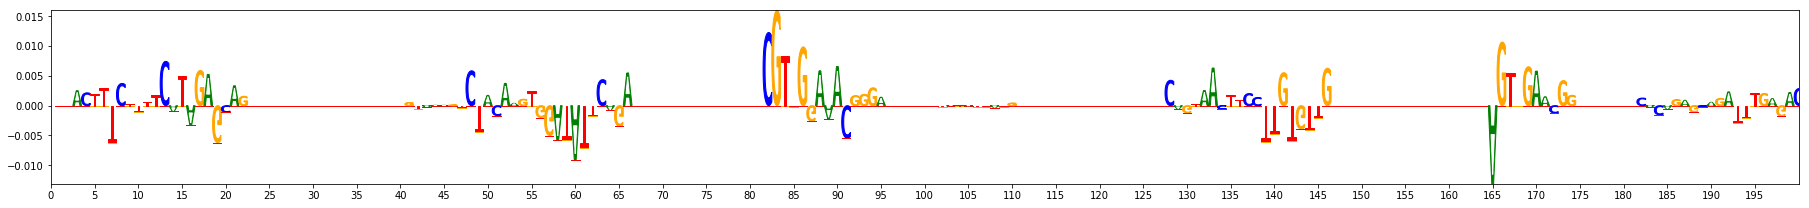

In [93]:
plot_seq_importance(deep_lift_scores[1].squeeze()[450:650],deep_lift_input[1].squeeze()[450:650])

In [54]:
#get the model predictions on the positives in train set (needed for relabeling)
pos_train_predict_gen=DataGenerator("SPI1.train.positives.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)
pos_train_predictions=spi1_regression_model.predict_generator(pos_train_predict_gen,
                                              max_queue_size=5000, 
                                              workers=50, 
                                              use_multiprocessing=True, 
                                              verbose=1)

137/137 [==============================] - 16s 117ms/step


In [55]:
#get the model predictions on the validation set (needed for relabeling)
pos_valid_predict_gen=DataGenerator("SPI1.valid.positives.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)
pos_valid_predictions=spi1_regression_model.predict_generator(pos_valid_predict_gen,
                                              max_queue_size=5000, 
                                              workers=50, 
                                              use_multiprocessing=True, 
                                              verbose=1)

25/25 [==============================] - 9s 372ms/step


In [61]:
#Store the  predictions 
import h5py 
predictions=h5py.File("predictions.hdf5",'w')
predictions.create_dataset("pos_valid",data=pos_valid_predictions)
predictions.create_dataset("pos_train",data=pos_train_predictions)
predictions.close() 

## Relabel training/validation positives <a name='5'>
<a href=#outline>Home</a>

In [62]:
import pandas as pd 
train_set=pd.read_hdf("SPI1.train.regression.hdf5",index_col=[0,1,2])
validation_set=pd.read_hdf("SPI1.valid.regression.hdf5",index_col=[0,1,2])

In [106]:
train_set_pos=pd.read_hdf("SPI1.train.positives.regression.hdf5",index_col=[0,1,2])
validation_set_pos=pd.read_hdf("SPI1.valid.positives.regression.hdf5",index_col=[0,1,2])

In [83]:
#0.1 was the minimum value observed in a positive bin 
pos_train_predictions[pos_train_predictions<0.1]=0.1
pos_valid_predictions[pos_valid_predictions<0.1]=0.1

In [94]:
train_set.shape


(49694107, 1)

In [99]:
pos_train_predictions.shape

(136284, 1)

In [108]:
train_set_pos.head


<bound method NDFrame.head of                               SPI1
CHR  START     END                
chr3 260750    261750     0.364782
     260800    261800     0.330169
     260850    261850     0.348605
     260900    261900     0.274468
     319550    320550     0.191052
     319600    320600     0.177743
     319650    320650     0.177743
     319700    320700     0.138188
     320450    321450     0.167341
     320500    321500     0.192118
     320550    321550     0.181418
     320600    321600     0.193433
     331650    332650     0.275411
     331700    332700     0.336643
     331750    332750     0.355753
     331800    332800     0.345424
     506000    507000     0.164742
     506050    507050     0.158446
     506100    507100     0.154456
     506150    507150     0.146834
     521750    522750     0.418478
     521800    522800     0.440707
     521850    522850     0.389213
     521900    522900     0.397847
     599600    600600     0.748761
     599650    600650    

In [109]:
#the dataframe size is not an even multiple of batch size, so we truncate some of the trailing values
pos_train_index=train_set_pos.index 
pos_valid_index=validation_set_pos.index

In [110]:
pos_train_index.shape

(136284,)

In [111]:
pos_train_predictions=pd.DataFrame(data=pos_train_predictions,index=pos_train_index,columns=['SPI1'])
pos_valid_predictions=pd.DataFrame(data=pos_valid_predictions,index=pos_valid_index,columns=['SPI1'])

In [112]:
#update the positive values in place 
train_set.update(pos_train_predictions)
validation_set.update(pos_valid_predictions)

In [113]:
#Store the updated training & validation labels to hdf5 
train_set.to_hdf("SPI1.train.relabeled.hdf5",key='data',mode='w',format='table')

In [114]:
validation_set.to_hdf("SPI1.valid.relabeled.hdf5",key='data',mode='w',format='table')

## Continue training model starting from early stopping state with relabeled set of labels <a name='6'>
<a href=#outline>Home</a>

In [116]:
#create the generator for keras training. Guarantee 30% positives in each batch 
train_gen2=DataGenerator("SPI1.train.relabeled.hdf5","/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample_ratio=0.3, upsample_thresh=0.1)
#create the generator for keras validation. Guarantee 30% positives in each batch 
valid_gen2=DataGenerator("SPI1.valid.relabeled.hdf5","/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample_ratio=0.3, upsample_thresh=0.1)
#create test set generator for prediction 
test_gen2=DataGenerator("SPI1.test.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)

In [117]:
from keras.models import load_model
#Start at best epoch from early stopping 
spi1_regression_model2=load_model('SPI1.regression.model.hdf5')

In [118]:
spi1_regression_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 991, 15)        615       
_________________________________________________________________
activation_8 (Activation)    (None, 1, 991, 15)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 991, 15)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 28, 15)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 19, 10)         1510      
_________________________________________________________________
activation_9 (Activation)    (None, 1, 19, 10)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 19, 10)         0         
__________

In [119]:
#Train the CTCF model 
## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history2=spi1_regression_model2.fit_generator(train_gen2,
                                 validation_data=valid_gen2,
                                 steps_per_epoch=1000,
                                 validation_steps=1000,
                                 epochs=50,
                                 verbose=1,
                                 use_multiprocessing=True,
                                 workers=50,
                                 max_queue_size=100,
                                 callbacks=[History()])

Epoch 1/50
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0204 - val_loss: 0.0190
Epoch 2/50
1000/1000 [==============================] - 45s 45ms/step - loss: 0.0213 - val_loss: 0.0186
Epoch 3/50
1000/1000 [==============================] - 46s 46ms/step - loss: 0.0213 - val_loss: 0.0185
Epoch 4/50
1000/1000 [==============================] - 49s 49ms/step - loss: 0.0216 - val_loss: 0.0189
Epoch 5/50
1000/1000 [==============================] - 41s 41ms/step - loss: 0.0209 - val_loss: 0.0197
Epoch 6/50
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0216 - val_loss: 0.0194
Epoch 7/50
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0207 - val_loss: 0.0188
Epoch 8/50
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0215 - val_loss: 0.0197
Epoch 9/50
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0211 - val_loss: 0.0196
Epoch 10/50
1000/1000 [==============================] - 44s 4

In [120]:
loss2=pd.DataFrame(history2.history)
loss2['epoch']=list(loss2.index)


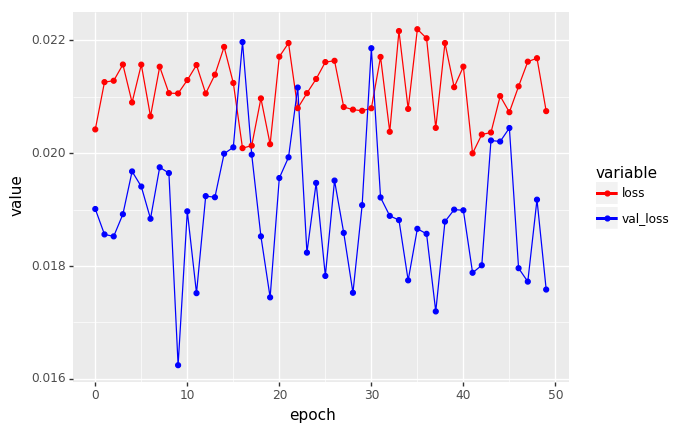

<ggplot: (-9223363258387274545)>

In [121]:
#Plot the loss curves 
from plotnine import *
subset2 = pd.melt(loss2, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
p2 = ggplot(subset2, aes(x='epoch', y='value', color='variable'))
(p2 + geom_line()
   + geom_point()
   + scale_color_manual(['r', 'b'])
)

## Performance and Interpretation on Round 2 <a name='7'>
<a href=#outline>Home</a>

In [122]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions2=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 743s 123ms/step


In [123]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions2)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions2)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.20853126], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.13863210928388475, pvalue=0.0)


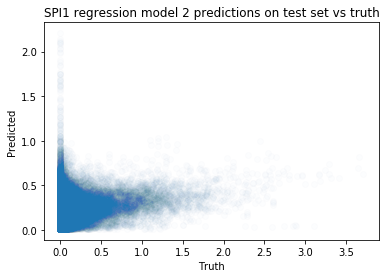

In [124]:
plt.scatter(spi1_test_regression_truth, spi1_test_regression_predictions2, alpha=0.01)
plt.xlabel("Truth")
plt.ylabel("Predicted")
plt.title("SPI1 regression model 2 predictions on test set vs truth")
plt.show()

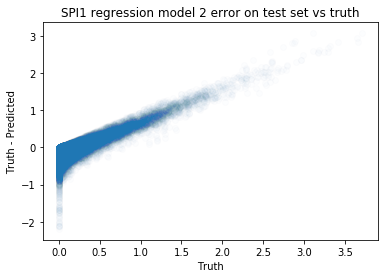

In [125]:
#plot truth vs error to see if we are overfitting to the positives 
error=spi1_test_regression_truth - spi1_test_regression_predictions2 
plt.scatter(spi1_test_regression_truth, error, alpha=0.01)
plt.xlabel("Truth")
plt.ylabel("Truth - Predicted")
plt.title("SPI1 regression model 2 error on test set vs truth")
plt.show()

## Conclusions<a name='8'>
<a href=#outline>Home</a>